# Copyright Netherlands eScience Center <br>
** Function     : Testing BayesConvLSTM with Lorens-84 model** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2020.03.31 ** <br>
** Last Update  : 2020.03.31 ** <br>
** Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, dlacs, matplotlib **<br>
Description     : This notebook serves to predict the Lorens 84 model using deep learning. The Bayesian Convolutional Long Short Time Memory neural network is used for testing. We use Pytorch as the deep learning framework. <br>
<br>

The Lorens-84 model is described by Edward Lorens in his 1984 paper:<br>
Lorenz, E. N. (1984). Irregularity: A fundamental property of the atmosphere. Tellus A, 36(2), 98-110.<br>

Return Values   : Time series and figures <br>

In [2]:
%matplotlib inline

import sys
import warnings
import numbers

# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import sklearn
#import scipy
import torch
import torch.nn.functional

#sys.path.append(os.path.join('C:','Users','nosta','ML4Climate','Scripts','DLACs'))
#sys.path.append("C:\\Users\\nosta\\ML4Climate\\Scripts\\DLACs")
sys.path.append("../")
import dlacs
import dlacs.BayesConvLSTM
import dlacs.preprocess
import dlacs.function
import dlacs.saveNetCDF

# for visualization
import dlacs.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
import iris # also helps with regriding
import cartopy
import cartopy.crs as ccrs

# ignore all the DeprecationWarnings by pytorch
if not sys.warnoptions:
    warnings.simplefilter("ignore")

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [3]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2500000,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

In [4]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
output_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps'

In [5]:
if __name__=="__main__":
    #################################################################################
    ###########                configure Lorenz 84 model                  ###########
    #################################################################################
    # Lorenz paramters and initial conditions
    x_init = 0.1 # strength of the symmetric globally encircling westerly current
    y_init = 0.1 # strength of the cosine phases of a chain of superposedwaves (large scale eddies)
    z_init = 0.1 # strength of the sine phases of a chain of superposedwaves (large scale eddies)
    F = 8.0 # thermal forcing term
    G = 1.0 # thermal forcing term
    a = 0.25 # stiffness factor for westerly wind x
    b = 4.0 # advection strength of the waves by the westerly current
    
    # assuming the damping time for the waves is 5 days (Lorens 1984)
    dt = 0.0333 # 1/30 unit of time unit (5 days)
    num_steps = 6000

In [6]:
    #################################################################################
    ###########                     Lorens 84 model                       ###########
    #################################################################################    
    def lorenz84(x, y, z, a = 0.25, b = 4.0, F = 8.0, G = 1.0):
        """
        Solver of Lorens-84 model.
        param x, y, z: location in a 3D space
        param a, b, F, G: constants and forcing
        """
        dx = - y**2 - z**2 - a * x + a * F
        dy = x * y - b * x * z - y + G
        dz = b * x * y + x * z - z
        
        return dx, dy, dz       

In [7]:
    #################################################################################
    ###########                 Launch Lorenz 84 model                    ###########
    #################################################################################   
    # Need one more for the initial values
    x = np.empty(num_steps + 1)
    y = np.empty(num_steps + 1)
    z = np.empty(num_steps + 1)
    
    # save initial values
    x[0] = x_init
    y[0] = y_init
    z[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps):
        dx, dy, dz = lorenz84(x[i], y[i], z[i])
        x[i + 1] = x[i] + (dx * dt)
        y[i + 1] = y[i] + (dy * dt)
        z[i + 1] = z[i] + (dz * dt)

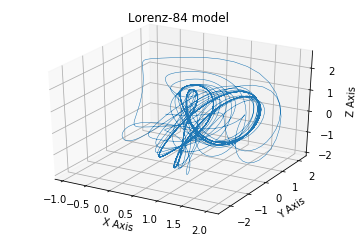

In [8]:
    #################################################################################
    ###########                 Visualize Lorens 84 model                    ###########
    #################################################################################   
    # save Lorens model output
    # Plot
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(x, y, z, lw=0.5)
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    ax.set_title("Lorenz-84 model")
    plt.show()
    fig.savefig(os.path.join(output_path,'lorenz84_a{}_b{}_F{}_G{}.png'.format(a, b, F, G)),dpi=200)

# Forecast with BayesConvLSTM <br>
** We use Pytorth to implement BayesConvLSTM neural network to deal with the Lorenz 84 model output. ** <br>

In [9]:
    print ('*******************  create basic dimensions for tensor and network  *********************')
    # specifications of neural network
    input_channels = 3
    #hidden_channels = [3, 2, 1] # number of channels & hidden layers, the channels of last layer is the channels of output, too
    hidden_channels = [3]
    kernel_size = 1
    # here we input a sequence and predict the next step only
    #step = 1 # how many steps to predict ahead
    #effective_step = [0] # step to output
    batch_size = 1
    #num_layers = 1
    learning_rate = 0.01
    num_epochs = 800
    print ('*******************  testing data  *********************')
    test_len = 500
    print ('*******************  check the environment  *********************')
    print ("Pytorch version {}".format(torch.__version__))
    # check if CUDA is available
    use_cuda = torch.cuda.is_available()
    print("Is CUDA available? {}".format(use_cuda))
    # CUDA settings torch.__version__ must > 0.4
    # !!! This is important for the model!!! The first option is gpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   
    print ('*******************  run BayesConvLSTM  *********************')
    print ('The model is designed to make many to one prediction.')
    print ('A series of multi-chanel variables will be input to the model.')
    print ('The model learns by verifying the output at each timestep.')
    # check the sequence shape
    sequence_len = num_steps
    height = 1
    width = 1
    # initialize our model
    model = dlacs.BayesConvLSTM.BayesConvLSTM(input_channels, hidden_channels, kernel_size).to(device)
    # use Evidence Lower Bound (ELBO) to quantify the loss
    ELBO = dlacs.function.ELBO(height*width)
    # penalty for kl
    penalty_kl = sequence_len
    # stochastic gradient descent
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # Adam optimizer
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(model)
    print(ELBO)
    print(optimiser)

*******************  create basic dimensions for tensor and network  *********************
*******************  testing data  *********************
*******************  check the environment  *********************
Pytorch version 1.1.0
Is CUDA available? True
*******************  run BayesConvLSTM  *********************
The model is designed to make many to one prediction.
A series of multi-chanel variables will be input to the model.
The model learns by verifying the output at each timestep.
!@#$% The network will be built with reduced size BayesConvLSTM cell. !@#$%
BayesConvLSTM(
  (cell0): BayesConvLSTMCell()
)
ELBO(
  (loss_function): MSELoss()
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)


In [10]:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print (name)
            print (param.data)
            print (param.size())
            print ("=========================")

cell0.Wxi_mu
tensor([[[[ 0.2857]],

         [[ 0.0328]],

         [[-0.3723]]],


        [[[ 0.3957]],

         [[-0.1405]],

         [[ 0.2844]]],


        [[[ 0.3758]],

         [[ 0.5364]],

         [[ 0.0940]]]], device='cuda:0')
torch.Size([3, 3, 1, 1])
cell0.Whi_mu
tensor([[[[ 0.2743]],

         [[ 0.5591]],

         [[ 0.0076]]],


        [[[-0.5270]],

         [[ 0.5147]],

         [[ 0.2577]]],


        [[[ 0.2444]],

         [[-0.4864]],

         [[ 0.2861]]]], device='cuda:0')
torch.Size([3, 3, 1, 1])
cell0.Wxf_mu
tensor([[[[-0.0373]],

         [[-0.4655]],

         [[-0.3296]]],


        [[[-0.3324]],

         [[-0.2951]],

         [[ 0.4677]]],


        [[[ 0.3970]],

         [[ 0.3413]],

         [[ 0.2511]]]], device='cuda:0')
torch.Size([3, 3, 1, 1])
cell0.Whf_mu
tensor([[[[-0.1269]],

         [[-0.4081]],

         [[ 0.5588]]],


        [[[-0.3188]],

         [[-0.4038]],

         [[ 0.0182]]],


        [[[-0.5761]],

         [[-0.1297]],

In [ ]:
    print('##############################################################')
    print('#############  preview model parameters matrix  ###############')
    print('##############################################################')
    print('Number of parameter matrices: ', len(list(model.parameters())))
    for i in range(len(list(model.parameters()))):
        print(list(model.parameters())[i].size())

In [11]:
    %%time
    print('##############################################################')
    print('##################  start training loop  #####################')
    print('##############################################################')
    # track training loss
    hist = np.zeros(num_epochs)
    hist_likelihood = np.zeros(num_epochs)
    hist_complexity = np.zeros(num_epochs)
    # loop of epoch
    for t in range(num_epochs):
        # Clear stored gradient
        model.zero_grad()
        # loop of timestep
        for timestep in range(sequence_len - test_len):
            # hidden state re-initialized inside the model when timestep=0
            #################################################################################
            ########          create input tensor with multi-input dimension         ########
            #################################################################################
            # create variables
            x_input = np.stack((x[timestep], y[timestep], z[timestep])) #vstack,hstack,dstack
            x_var = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width)).to(device)
            #################################################################################
            ########       create training tensor with multi-input dimension         ########
            #################################################################################
            y_train_stack = np.stack((x[timestep+1], y[timestep+1], z[timestep+1])) #vstack,hstack,dstack
            y_var = torch.autograd.Variable(torch.Tensor(y_train_stack).view(-1,hidden_channels[-1],height,width)).to(device)
            #################################################################################   
            # Forward pass
            y_pred, kl_loss, _ = model(x_var, timestep)
            # choose training data
            y_target = y_var
            # torch.nn.functional.mse_loss(y_pred, y_train) can work with (scalar,vector) & (vector,vector)
            # Please Make Sure y_pred & y_train have the same dimension
            # accumulate loss
            if timestep == 0:
                loss, likelihood, complexity = ELBO(y_pred, y_target, kl_loss,
                                                    1 / (len(hidden_channels) * 8 * penalty_kl * kernel_size**2))
            else:
                loss_step, likelihood_step,\
                complexity_step = ELBO(y_pred, y_target, kl_loss,
                                       1 / (len(hidden_channels) * 8 * penalty_kl * kernel_size**2))
                loss += loss_step
                likelihood += likelihood_step
                complexity += complexity_step           
        #print(y_pred.shape)
        #print(y_train.shape)
        # print loss at certain iteration
        if t % 10 == 0:
            print("Epoch {} ELBO: {:0.3f}".format(t, loss.item()))
            print("likelihood cost {:0.3f} #*# complexity cost {:0.3f}".format(likelihood.item(), complexity.item()))
            # gradient check
            # Gradcheck requires double precision numbers to run
            #res = torch.autograd.gradcheck(loss_fn, (y_pred.double(), y_train.double()), eps=1e-6, raise_exception=True)
            #print(res)
        hist[t] = loss.item()
        hist_likelihood[t] = likelihood.item()
        hist_complexity[t] = complexity.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()
    
        # Backward pass
        loss.backward()

        # Update parametersdd
        optimiser.step()
        
    # save the model
    # (recommended) save the model parameters only
    torch.save(model.state_dict(), os.path.join(output_path,'bayesconvlstm_lorenz84.pkl'))
    # save the entire model
    # torch.save(model, os.path.join(output_path,'bayesconvlstm.pkl'))

##############################################################
##################  start training loop  #####################
##############################################################
Epoch 0 ELBO: 5165.754
likelihood cost 5162.950 #*# complexity cost 2.811


KeyboardInterrupt: 

In [ ]:
    print ("*******************  Loss with time  **********************")
    fig00 = plt.figure()
    plt.plot(hist, 'r', label="Training loss")
    plt.plot(hist_likelihood, 'g', label="Likelihood loss")
    plt.plot(hist_complexity, 'b', label="Complexity loss")
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    fig00.savefig(os.path.join(output_path,'SIC_ERAI_BayesConvLSTM_pred_error_Lorenz84.png'),dpi=200)
    
    print ("*******************  Loss with time (log)  **********************")
    fig01 = plt.figure()
    plt.plot(np.log(hist), 'r', label="Training loss")
    plt.plot(np.log(hist_likelihood), 'g', label="Likelihood loss")
    plt.plot(np.log(hist_complexity), 'b', label="Complexity loss")
    plt.xlabel('Epoch')
    plt.ylabel('Log error')
    plt.legend()
    plt.show()
    fig01.savefig(os.path.join(output_path,'SIC_ERAI_BayesConvLSTM_pred_log_error_Lorenz84.png'),dpi=200)